In [378]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [379]:
import os, sys
import numpy as np
from collections import OrderedDict as OD
import math
#import uproot3
import uproot as uproot
import hist
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import enum
import mplhep as hep
from parse import *


sys.path.insert(1, '../') # to import file from other directory (../ in this case)

from htoaa_Settings import *

#sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230831_SelPNetMDXbbNSV/2018/analyze_htoaa_stage1.root'
#sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230831_SelPNetMDXbbNSV/2018/plots'
#sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230921_SFPNetMDXbbvsQCD/2018/analyze_htoaa_stage1.root'
#sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230921_SFPNetMDXbbvsQCD/2018/plots'
sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230922_DataSplitByEra/2018/analyze_htoaa_stage1.root'
sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230922_DataSplitByEra/2018/plots'



if not os.path.exists(sOpDir):
    os.makedirs(sOpDir)
    
fIpFile = uproot.open(sIpFile)

In [380]:
#fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150'].keys()

In [381]:
#h = fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150/hLeadingFatJetMass_central']

In [382]:
#fIpFile['evt'].keys()

In [383]:
#fIpFile['evt/Data'].keys()

In [384]:
#fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150/hLeadingFatJetNConstituents_sel_leadingFatJetParticleNetMD_XbbvsQCD_central'].to_hist()

In [385]:
#fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150/hLeadingFatJetNConstituents_sel_leadingFatJetParticleNetMD_XbbvsQCD_central'].to_hist().values()


In [386]:
def rebinTH1(h1_, nRebins):
    #print(f"rebinTH1():: histogram type {type(h1_) = },  {isinstance(h1_, hist.Hist) = }  ")
    if not isinstance(h1_, hist.Hist):
        print(f"rebinTH1():: histogram type {type(h1_)} not implemented... so could not rebin histogram ")
        return h1_
    
    if len(h1_.axes) != 1:
        print(f"rebinTH1:: histogram is not 1D")
        return h1_

    h1Rebin_ = None
    if   nRebins == 1:
        h1Rebin_ = h1_
    elif   nRebins == 2:
        h1Rebin_ = h1_[::2j]
    elif nRebins == 3:
        h1Rebin_ = h1_[::3j]
    elif nRebins == 4:
        h1Rebin_ = h1_[::4j]
    elif nRebins == 5:
        h1Rebin_ = h1_[::5j]
    elif nRebins == 6:
        h1Rebin_ = h1_[::6j]
    elif nRebins == 10:
        h1Rebin_ = h1_[::10j]
    elif nRebins == 20:
        h1Rebin_ = h1_[::20j]
    elif nRebins == 40:
        h1Rebin_ = h1_[::40j]
    elif nRebins == 50:
        h1Rebin_ = h1_[::50j]
    elif nRebins == 100:
        h1Rebin_ = h1_[::100j]
        print("Rebin 100 <<<")
    else:
        print(f"nRebins={nRebins} is not yet implemented... Implement it \t\t **** ERROR ****")        
        
    #print(f"h1_ values ({len(h1_.values())}): {h1_.values()} \n variances ({len(h1_.variances())}): {h1_.variances()}")
    #print(f"h1Rebin_ values ({len(h1Rebin_.values())}): {h1Rebin_.values()} \n variances ({len(h1Rebin_.variances())}): {h1Rebin_.variances()}")
    if   nRebins > 1:    
        h1_ = h1Rebin_

    return h1_

In [387]:
def rebinTH2(h1_, nRebinX, nRebinY):
    #print(f"rebinTH1():: histogram type {type(h1_) = },  {isinstance(h1_, hist.Hist) = }  ")
    if not isinstance(h1_, hist.Hist):
        print(f"rebinTH1():: histogram type {type(h1_)} not implemented... so could not rebin histogram ")
        return h1_
    
    if len(h1_.axes) != 2:
        print(f"rebinTH1:: histogram is not 2D")
        return h1_

    h1Rebin_ = None
    if   nRebinX == 1:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::1j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::1j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::1j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::1j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::1j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::1j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::1j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::1j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::1j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::1j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 2:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::2j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::2j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::2j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::2j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::2j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::2j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::2j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::2j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::2j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::2j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 3:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::3j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::3j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::3j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::3j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::3j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::3j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::3j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::3j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::3j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::3j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 4:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::4j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::4j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::4j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::4j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::4j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::4j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::4j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::4j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::4j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::4j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 5:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::5j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::5j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::5j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::5j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::5j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::5j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::5j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::5j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::5j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::5j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 6:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::6j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::6j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::6j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::6j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::6j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::6j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::6j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::6j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::6j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::6j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    elif   nRebinX == 10:
        if   nRebinY == 1:
            h1Rebin_ = h1_
        elif nRebinY == 2:
            h1Rebin_ = h1_[::10j, ::2j]
        elif nRebinY == 3:
            h1Rebin_ = h1_[::10j, ::3j]
        elif nRebinY == 4:
            h1Rebin_ = h1_[::10j, ::4j]
        elif nRebinY == 5:
            h1Rebin_ = h1_[::10j, ::5j]
        elif nRebinY == 6:
            h1Rebin_ = h1_[::10j, ::6j]
        elif nRebinY == 10:
            h1Rebin_ = h1_[::10j, ::10j]
        elif nRebinY == 20:
            h1Rebin_ = h1_[::10j, ::20j]
        elif nRebinY == 40:
            h1Rebin_ = h1_[::10j, ::40j]
        elif nRebinY == 50:
            h1Rebin_ = h1_[::10j, ::50j]
        elif nRebinY == 100:
            h1Rebin_ = h1_[::10j, ::100j]
        else:
            print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")        

    else:
        print(f"{nRebinX = }, {nRebinY = } is not yet implemented... Implement it \t\t **** ERROR ****")   

       
    #print(f"h1_ values ({len(h1_.values())}): {h1_.values()} \n variances ({len(h1_.variances())}): {h1_.variances()}")
    #print(f"h1Rebin_ values ({len(h1Rebin_.values())}): {h1Rebin_.values()} \n variances ({len(h1Rebin_.variances())}): {h1Rebin_.variances()}")
    if   nRebinX > 1 or nRebinY > 1 :    
        h1_ = h1Rebin_

    return h1_

In [388]:
def getNonZeroMin(arr):
    min_ = 1e20
    a_   = arr[np.nonzero(arr)]
    if len(a_) > 0:
        min_ = np.min( a_ )
    return min_


In [389]:
# Function to draw box error bars
# https://matplotlib.org/stable/gallery/statistics/errorbars_and_boxes.html#sphx-glr-gallery-statistics-errorbars-and-boxes-py
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='lightgrey',
                     edgecolor='none', alpha=0.5):

    # Loop over data points; create box from errors at each point
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
    # matplotlib.patches.Rectangle(xy, width, height, *, angle=0.0, rotation_point='xy', **kwargs)
    #errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
    #              for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]
    errorboxes = [Rectangle((x - xe, y - ye), 2*xe, 2*ye)
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    artists = None
    # Plot errorbars
    #artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
    #                      fmt='none', ecolor=facecolor)

    return artists

ExpData_list = ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'], DatasetEra_ = 'A', luminosity_forEra_ = 8.736 
ExpData_list = ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'], DatasetEra_ = 'B', luminosity_forEra_ = 7.067 
ExpData_list = ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'], DatasetEra_ = 'C', luminosity_forEra_ = 6.895 
ExpData_list = ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'], DatasetEra_ = 'D', luminosity_forEra_ = 31.839 
Data ABCD: ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'], luminosity_toUse = 54.54, luminosity_total = 54.54,  luminosity_Scaling_toUse = 1.0


 histo_name_toUse = 'hLeadingFatJetEta_vs_Phi_sel_leadingFatJetParticleNetMD_XbbvsQCD', systematic = 'central', yAxisScale = 'linearY', 
len(hStack_list) = 11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ratio_values ((50, 50)): [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


 histo_name_toUse = 'hLeadingFatJetEta_vs_Phi_sel_leadingFatJetParticleNetMD_XbbvsQCD', systematic = 'central', yAxisScale = 'logY', 


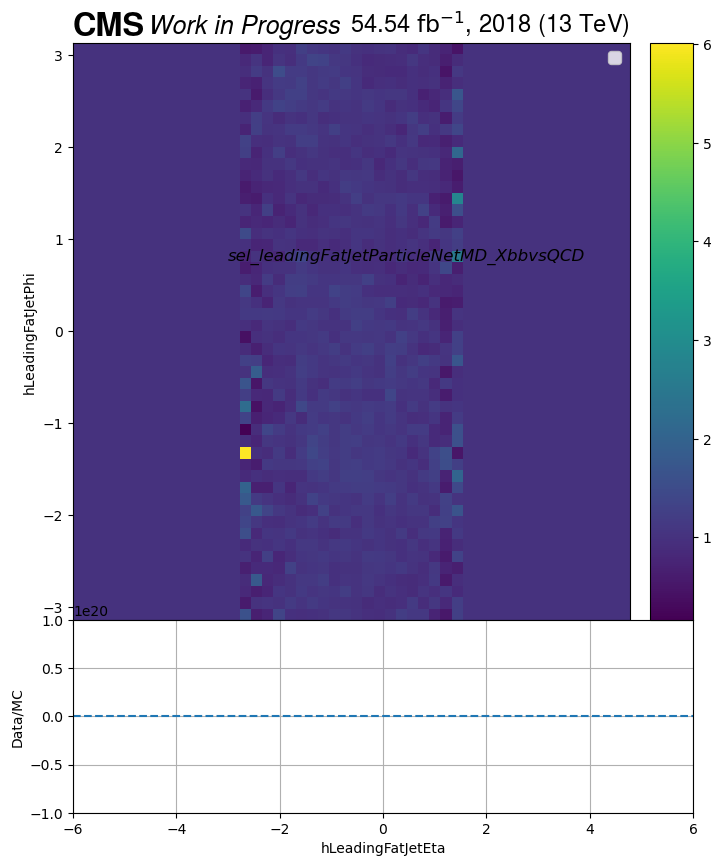

In [390]:
sXRange = "xAxisRange"; sYRange = "yAxisRange";
sXLabel = 'xAxisLabel'; sYLabel = 'yAxisLabel';
sNRebinX = 'nRebinX';  sNRebinY = 'nRebinY'; 

class DataBlindingOptions(enum.Enum):
    BlindPartially = '(partially blind)'
    BlindFully     = '(blind)'
    Unblind        = ' '

era = '2018'
luminosity_total = Luminosities_forGGFMode[era][0] # 54.54  #59.83
cmsWorkStatus='Work in Progress'


dataBlindOption = DataBlindingOptions.Unblind # DataBlindingOptions.BlindPartially , DataBlindingOptions.BlindFully , DataBlindingOptions.Unblind
ExpData_dict = {
    'Data ABCD': ['JetHT_Run2018A', 'JetHT_Run2018B', 'JetHT_Run2018C', 'JetHT_Run2018D'],
    #'Data A': ['JetHT_Run2018A'],
    #'Data B': ['JetHT_Run2018B'],
    #'Data C': ['JetHT_Run2018C'],
    #'Data D': ['JetHT_Run2018D']
}
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_HT', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_Incl', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat',  'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
MCBkg_list = ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat',  'TTToHadronic_powheg', 'TTToSemiLeptonic_powheg', 'TTTo2L2Nu_powheg', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
MCSig_list = ['SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150', 'SUSY_GluGluH_01J_HToAATo4B_M-30_HPtAbv150', ]
sLableSig = ['HToAATo4B_M-20', 'HToAATo4B_M-30']
systematics_list = ['central']
systematics_forData = 'noweight'
selectionTags = ['sel_leadingFatJetParticleNetMD_XbbvsQCD'] # ['sel_leadingFatJetMSoftDrop', 'sel_leadingFatJetParticleNetMD_XbbvsQCD', 'SR'] #['SR', 'sel_leadingFatJetMSoftDrop', 'sel_leadingFatJetParticleNetMD_XbbvsQCD', 'sel_2018HEM1516Issue']


scale_MCSig = 50 #1000
yRatioLimit = [0.4, 1.6]

logYMinScaleFactor = 10 # 100 # 1 # scale yMin by factor logYMinScaleFactor to not concentrate lowest stats background processes

significantThshForDataBlinding = 0.125 # blind data in bins with S/sqrt(B) > significantThshForDataBlinding while running with dataBlindOption = DataBlindingOptions.BlindPartially


histograms_dict = OD([
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250], sYRange: [1e-2, 1e8]})
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250]}),
    
    #("", {sXLabel: '', sYLabel: 'Events', sXRange: []}),
    
    #("hCutFlow", {sXLabel: 'hCutFlow', sYLabel: 'Events'}),
    #("hCutFlowWeighted", {sXLabel: 'hCutFlowWeighted', sYLabel: 'Events'}),

    #("hPV_npvs_beforeSel", {sXLabel: 'No. of primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvsGood_beforeSel", {sXLabel: 'No. of good primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvs_SR", {sXLabel: 'No. of primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvsGood_SR", {sXLabel: 'No. of good primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),

    ("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta", {sXLabel: 'hLeadingFatJetEta', sYLabel: 'Events', sXRange: [-3.5, 3.5], sNRebinX: 2 }),
    ("hLeadingFatJetPhi", {sXLabel: 'hLeadingFatJetPhi', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),

    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    #("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    #("hLeadingFatJetEta_HEM1516IssuePhiCut_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    #("hLeadingFatJetPhi_HEM1516IssueEtaCut_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    #("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    #("hLeadingFatJetEta_HEM1516IssuePhiCut_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    #("hLeadingFatJetPhi_HEM1516IssueEtaCut_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),

    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4  }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4  }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516Fix_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516Fix_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516Fix_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),

    # 2018 HEM15/16 issue validation
    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt_DataPreHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt_DataPreHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),
    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut_woHEM1516MCRewgt_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut_woHEM1516MCRewgt_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt_DataWithHEM1516Issue", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut_woHEM1516MCRewgt_DataWithHEM1516Issue', sYLabel: 'Events', sXRange: [-3.14, 3.14], sNRebinX: 2 }),

    ("hLeadingFatJetMass", {sXLabel: 'hLeadingFatJetMass', sYLabel: 'Events', sXRange: [50, 300], sNRebinX: 5}),
    ("hLeadingFatJetMSoftDrop", {sXLabel: 'hLeadingFatJetMSoftDrop', sYLabel: 'Events', sXRange: [50, 300], sNRebinX: 5 }),
    ("hLeadingFatJetBtagDeepB", {sXLabel: 'hLeadingFatJetBtagDeepB', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetBtagDDBvLV2", {sXLabel: 'hLeadingFatJetBtagDDBvLV2', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetBtagDDCvBV2", {sXLabel: 'hLeadingFatJetBtagDDCvBV2', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetBtagHbb", {sXLabel: 'hLeadingFatJetBtagHbb', sYLabel: 'Events', sXRange: [-1, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_H4qvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_HbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_ZHbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHbbvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_ZHccvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHccvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetDeepTagMD_ZbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZbbvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_ZvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_bbvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_bbvsLight', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTagMD_ccvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_ccvsLight', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTag_H", {sXLabel: 'hLeadingFatJetDeepTag_H', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetDeepTag_QCD", {sXLabel: 'hLeadingFatJetDeepTag_QCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetDeepTag_QCDothers", {sXLabel: 'hLeadingFatJetDeepTag_QCDothers', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetN2b1", {sXLabel: 'hLeadingFatJetN2b1', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetN3b1", {sXLabel: 'hLeadingFatJetN3b1', sYLabel: 'Events', sXRange: [0, 5], sNRebinX: 2 }),
    ("hLeadingFatJetTau1", {sXLabel: 'hLeadingFatJetTau1', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetTau2", {sXLabel: 'hLeadingFatJetTau2', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetTau3", {sXLabel: 'hLeadingFatJetTau3', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetTau4", {sXLabel: 'hLeadingFatJetTau4', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetTau4by3", {sXLabel: 'hLeadingFatJetTau4by3', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetTau3by2", {sXLabel: 'hLeadingFatJetTau3by2', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetTau2by1", {sXLabel: 'hLeadingFatJetTau2by1', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetNConstituents", {sXLabel: 'hLeadingFatJetNConstituents', sYLabel: 'Events'}),
    ("hLeadingFatJetParticleNetMD_QCD", {sXLabel: 'hLeadingFatJetParticleNetMD_QCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetParticleNetMD_Xbb", {sXLabel: 'hLeadingFatJetParticleNetMD_Xbb', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetParticleNetMD_Xcc", {sXLabel: 'hLeadingFatJetParticleNetMD_Xcc', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),       
    ("hLeadingFatJetParticleNetMD_Xqq", {sXLabel: 'hLeadingFatJetParticleNetMD_Xqq', sYLabel: 'Events', sNRebinX: 2}),

    ("hLeadingFatJetParticleNetMD_XbbOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XbbOverQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }), 
    ("hLeadingFatJetParticleNetMD_XccOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XccOverQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }), 
    ("hLeadingFatJetParticleNetMD_XqqOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XqqOverQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }), 

    ("hLeadingFatJetParticleNet_H4qvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetParticleNet_HbbvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetParticleNet_HccvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HccvsQCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    ("hLeadingFatJetParticleNet_QCD", {sXLabel: 'hLeadingFatJetParticleNet_QCD', sYLabel: 'Events', sXRange: [0, 1], sNRebinX: 2 }),
    
    ("hLeadingFatJetParticleNet_mass", {sXLabel: 'hLeadingFatJetParticleNet_mass', sYLabel: 'Events', sXRange: [50, 300], sNRebinX: 5 }),

    ("hLeadingFatJet_nSubJets", {sXLabel: 'hLeadingFatJet_nSubJets', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSubJets_bTag_L", {sXLabel: 'hLeadingFatJet_nSubJets_bTag_L', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSubJets_bTag_M", {sXLabel: 'hLeadingFatJet_nSubJets_bTag_M', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSV", {sXLabel: 'hLeadingFatJet_nSV', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),

    ("hMET_pT", {sXLabel: 'hMET_pT', sYLabel: 'Events', sXRange: [0, 1000], sNRebinX: 5 }),
    ("hMET_sumEt", {sXLabel: 'hMET_sumEt', sYLabel: 'Events', sXRange: [0, 4000], sNRebinX: 5 }),

    ("hLeadingFatJet_nLeptons", {sXLabel: 'hLeadingFatJet_nLeptons', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),

    #("", {sXLabel: '', sYLabel: 'Events'}),
])

'''
histograms_dict = OD([
    ("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [180, 1000], sNRebinX: 4 }),
    #("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [800, 900], sYRange: [100, 1000] }),
])
'''

histograms_dict = OD([
    ("hLeadingFatJetEta_vs_Phi", {sXLabel: 'hLeadingFatJetEta', sYLabel: 'hLeadingFatJetPhi', sNRebinX: 2, sNRebinY: 2  }),
    #("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [800, 900], sYRange: [100, 1000] }),
])


#colors_bkg_list = ['blue', 'orange', 'brown'] # ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"] #['lightcoral', 'burlywood', 'cyan', 'saddlebrown', 'slateblue', 'lightpink', 'darkkhaki', 'antiquewhite', 'limegreen', 'violet', 'firebrick', 'darkorchid', 'tan', 'olive', 'purple']

colors_bkg_list = [ 
    # ['color', <transperent>, '<fill pattern>']
    ['lightcoral', 0.9, ''],
    ['cyan', 0.9, '' ],
    ['burlywood', 0.9, '' ], 
    ['saddlebrown', 0.9, '' ],
    ['slateblue', 0.9, '' ],
    ['lightpink', 0.9, 'xx' ],
    ['darkkhaki', 0.9, '' ],
    ['antiquewhite', 0.9, '//' ],
    ['limegreen', 0.9, '' ],
    ['violet', 0.9, '' ],
    ['firebrick', 0.9, '' ],
    ['darkorchid', 0.9, '' ],
    ['tan', 0.9, '' ],
    ['olive', 0.9, '' ],
    ['purple',  0.9, ''],
]

colors_sig_list = [
    # ['color', <transperent>, '<fill pattern>', ]
    ['blue', 0.9, ''],
    ['red', 0.9, ''],
    ['green', 0.9, ''],
]

for sData, ExpData_list in ExpData_dict.items():
    luminosity_toUse = 0
    for ExpData_component in ExpData_list:
        DatasetEra_         = ExpData_component.split(era)[1][0] # 'JetHT_Run2018A'.split('2018')[1][0]
        luminosity_forEra_  = Luminosities_forGGFMode_perEra[era][DatasetEra_]
        luminosity_toUse   += luminosity_forEra_
        print(f"{ExpData_list = }, {DatasetEra_ = }, {luminosity_forEra_ = } ")
    luminosity_Scaling_toUse = round(luminosity_toUse, 2) / round(luminosity_total, 2)
    luminosity_toUse = round(luminosity_toUse, 2)
    print(f"{sData}: {ExpData_list}, {luminosity_toUse = }, {luminosity_total = },  {luminosity_Scaling_toUse = }")

    for selectionTag in selectionTags:    
        dataBlindOption_toUse = dataBlindOption if selectionTag != 'SR' else DataBlindingOptions.BlindPartially
        for histo_name in histograms_dict.keys():
            histo_name_toUse = '%s_%s' % (histo_name, selectionTag)
            for systematic in systematics_list:
                for yAxisScale in ['linearY', 'logY']: # ['linearY', 'logY']
                    xAxisRange = histograms_dict[histo_name][sXRange] if sXRange in histograms_dict[histo_name].keys() else None
                    yAxisRange = histograms_dict[histo_name][sYRange] if sYRange in histograms_dict[histo_name].keys() else None
                    xAxisLabel = histograms_dict[histo_name][sXLabel] if sXLabel in histograms_dict[histo_name].keys() else None
                    yAxisLabel = histograms_dict[histo_name][sYLabel] if sYLabel in histograms_dict[histo_name].keys() else None
                    nRebinX    = histograms_dict[histo_name][sNRebinX] if sNRebinX in histograms_dict[histo_name].keys() else 1
                    nRebinY    = histograms_dict[histo_name][sNRebinY] if sNRebinY in histograms_dict[histo_name].keys() else 1

                    nHistoDimemsions = None
                    yAxisRange_cal      = [1e20, -1e10]
                    yRatioAxisRange_cal = [1e20, -1e10]
                    xError = np.array([])
                    hData = None
                    hBkgTot_values = None
                    hBkgTot_variance = None
                    hStack_values_list = np.array([]) 
                    hStack_edges = np.array([])
                    hStack_centers = np.array([])
                    sStack_list = []
                    nBkgTot = 0
                    significanceAvg = [] #np.array([])



                    print(f"\n\n {histo_name_toUse = }, {systematic = }, {yAxisScale = }, ")
                    #fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1]}, subplot_kw={'ymargin': 0.4})
                    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
                    #fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(8,10), sharex='col')
                    #print(f"fig: {fig}, axs: {axs}")

                    #fig1, ax1 = plt.subplots()
                    
                    
                    if len(MCBkg_list) > 0:
                        hBkg_list = []
                        sBkg_list = []
                        hBkg_integral_list = []
                        for dataset in MCBkg_list:
                            histo_name_toUse_full = 'evt/%s/%s_%s' % (dataset, histo_name_toUse, systematic)
                            h = fIpFile[histo_name_toUse_full].to_hist()
                            nHistoDimemsions = len(h.axes)
                            if nHistoDimemsions == 2 and yAxisScale == 'logY': break  # No need to plot 2-D hist with logY
                            h = rebinTH1(h, nRebinX) if nHistoDimemsions == 1 else rebinTH2(h, nRebinX, nRebinY)

                            h = h * luminosity_Scaling_toUse

                            nTot_ = h.values().sum()
                            hBkg_list.append(h)
                            sBkg_list.append(dataset)
                            hBkg_integral_list.append(nTot_)

                            if abs(nTot_ - 0) < 1e-10: continue
                            #print(f"{histo_name_toUse_full} integral: {h.values.sum()}")
                            #print(f"{h.axes = }, {len(h.axes) = }")

                            if nHistoDimemsions == 1:
                                yMin_ = getNonZeroMin(h.values())
                                yMax_ = np.max(h.values())
                                if yMin_ < yAxisRange_cal[0]:
                                    yAxisRange_cal[0] = yMin_
                                if yMax_ > yAxisRange_cal[1]:
                                    yAxisRange_cal[1] = yMax_                        

                        # No need to plot 2-D hist with logY
                        if nHistoDimemsions == 2 and yAxisScale == 'logY': 
                            plt.close(fig)
                            continue 


                        # sort histograms in decreasing yield
                        isReverseSortForStack = True
                        idx_hBkg_sortedByIntegral = sorted(range(len(hBkg_integral_list)), key=lambda i: hBkg_integral_list[i], reverse=isReverseSortForStack)            

                        #print(f"sBkg_list: {sBkg_list} \nhBkg_integral_list (total {sum(hBkg_integral_list)}): {hBkg_integral_list} ")
                        #print(f"sBkg_list sorted by integral: {[(sBkg_list[idx], hBkg_integral_list[idx]) for idx in idx_hBkg_sortedByIntegral]}")            

                        hStack_list = [ hBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                        sStack_list = [ sBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                        #print(f"sStack_list: {sStack_list}")
                        #print(f"xError ({type(xError)}) ({len(xError)}): {xError}")

                        hStack_values_list    = np.array( [ h.values() for h in hStack_list ] )
                        hStack_variance_list  = np.array( [ h.variances() for h in hStack_list ] )
                        hStack_error_list     = np.array( [ np.sqrt(h.variances()) for h in hStack_list ] )
                        print(f"{len(hStack_list) = }"); sys.stdout.flush()
                        hStack_edges          = hStack_list[0].axes[0].edges
                        hStack_centers        = hStack_list[0].axes[0].centers
                        xError                = (hStack_list[0].axes[0].edges[1:] - hStack_list[0].axes[0].edges[0:-1]) / 2 if len(xError) == 0 else xError

                        hBkgTot_values        = np.sum(hStack_values_list, axis=0)
                        hBkgTot_variance      = np.sum(hStack_variance_list, axis=0)
                        #print(f"hBkgTot_values sum: {sum(hBkgTot_values)}")

                        # Update yRange for hStackBkg -------
                        if nHistoDimemsions == 1:
                            yMin_ = getNonZeroMin(hBkgTot_values)
                            yMax_ = np.max(hBkgTot_values)
                            if yMin_ < yAxisRange_cal[0]:
                                yAxisRange_cal[0] = yMin_
                            if yMax_ > yAxisRange_cal[1]:
                                yAxisRange_cal[1] = yMax_    

                        nHists = len(MCBkg_list)
                        colors_toUse = [ colors_bkg_list[i][0] for i in range(nHists) ]
                        alpha_toUse  = [ colors_bkg_list[i][1] for i in range(nHists) ]
                        hatch_toUse  = [ colors_bkg_list[i][2] for i in range(nHists) ]

                        # plot stack
                        #hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='fill', stack=True, label=sStack_list, sort='yield')
                        #hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='step', stack=True, label=sStack_list, linestyle="--", color=["green", "black", (1, 0, 0, 0.4)])
                        #hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], histtype='fill', stack=True, label=sStack_list, color=["green", "darkorange", "red"])

                        # https://matplotlib.org/stable/gallery/shapes_and_collections/hatch_style_reference.html
                        
                        if nHistoDimemsions == 1: # 1-D histogram
                            hep.histplot(
                                hStack_values_list, 
                                bins=hStack_edges, 
                                ax=ax[0], 
                                histtype='fill', 
                                stack=True, 
                                label=sStack_list, 
                                color=colors_toUse,
                                alpha=alpha_toUse,
                                hatch=hatch_toUse,
                                sort='yield'
                                )

                            # plot total background
                            #hep.histplot(hBkgTot_values, bins=hStack_edges, ax=ax, yerr=np.sqrt(hBkgTot_variance), histtype='errorbar', color='grey', label='Total background')
                            
                            # plot totoal background error bars only
                            make_error_boxes(
                                ax=ax[0], 
                                xdata=hStack_centers, 
                                ydata=hBkgTot_values, 
                                xerror=xError, 
                                yerror=np.sqrt(hBkgTot_variance), 
                                facecolor='grey',
                                edgecolor='none', 
                                alpha=0.5
                                )
                            
                        elif nHistoDimemsions == 2 and 1==0: # 2-D histogram  
                            #print(f"{list(hStack_list[0].values()) = }, \n{hStack_list[0].variances() = }, ")
                            #print(f"{getNonZeroMin(h.values()) = }")
                            hep.hist2dplot(
                                hBkgTot_values,
                                xbins=hStack_list[0].axes[0].edges,
                                ybins=hStack_list[0].axes[1].edges,
                                #labels='Bkg_total',
                                cmin=getNonZeroMin(hStack_list[0].values()),
                                ax=ax[0]
                            )   
                        
                        # No. of events in total background
                        nBkgTot = np.sum(hBkgTot_values)


                        '''
                        if 1==1:
                            if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                            if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                            else:          ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1])
                            if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                            if yAxisLabel: ax[0].set_ylabel(yAxisLabel)
                        '''
                    #print(f"\nAfter MCBkg {yAxisRange_cal = }")




                    if len(MCSig_list) > 0:
                        hSig_list = []
                        sSig_list = []
                        hSig_integral_list = []
                        for iSig, dataset in enumerate(MCSig_list):
                            histo_name_toUse_full = 'evt/%s/%s_%s' % (dataset, histo_name_toUse, systematic)
                            h = fIpFile[histo_name_toUse_full].to_hist()
                            h = rebinTH1(h, nRebinX) if nHistoDimemsions == 1 else rebinTH2(h, nRebinX, nRebinY)

                            h = h * luminosity_Scaling_toUse

                            nTot_ = h.values().sum()
                            hSig_list.append(h)
                            sSig_list.append(dataset)
                            hSig_integral_list.append(h.values().sum())
                            #print(f"{histo_name_toUse_full} integral: {h.values().sum()}")

                            histo_edges = h.axes[0].edges
                            xError      = (h.axes[0].edges[1:] - h.axes[0].edges[0:-1]) / 2 if len(xError) == 0 else xError


                            label_MCSig = dataset
                            label_MCSig = sLableSig[iSig]
                            if scale_MCSig > 1:
                                #label_MCSig = '%s x %d' % (dataset, scale_MCSig)
                                label_MCSig = '%s x %d' % (label_MCSig, scale_MCSig)
                                
                            if nHistoDimemsions == 1:
                                yMin_ = getNonZeroMin(h.values())
                                yMax_ = np.max(h.values())
                                if yMin_ < yAxisRange_cal[0]:
                                    yAxisRange_cal[0] = yMin_
                                if yMax_ > yAxisRange_cal[1]:
                                    yAxisRange_cal[1] = yMax_                        

                            # plot signal
                            if nHistoDimemsions == 1:
                                hep.histplot(
                                    h.values() * scale_MCSig, 
                                    bins=histo_edges, 
                                    ax=ax[0], 
                                    yerr=np.sqrt(h.variances()) * scale_MCSig, 
                                    histtype='errorbar', 
                                    label=label_MCSig,
                                    color=colors_sig_list[iSig][0],                             
                                    marker='o',
                                    markerfacecolor=colors_sig_list[iSig][0],
                                    markersize=3
                                    )

                            nSig = np.sum(h.values())
                            # S/sqrt(B)
                            if nSig > 0 and nBkgTot > 0:
                                S_ = h.values() / nSig
                                B_ = np.sqrt(hBkgTot_values / nBkgTot)
                                significance_i = np.divide(S_, B_, where=B_!=0, out=np.zeros(B_.shape))
                                significanceAvg.append(significance_i)

                                #ax1.plot(h.axes[0].centers, significance_i)

                        significanceAvg = np.array(significanceAvg)
                        significanceAvg = np.sum(significanceAvg, axis=0)
                        significanceAvg = np.divide(significanceAvg, len(MCSig_list) )
                        #print(f"significanceAvg (max: {np.max(significanceAvg)}): {significanceAvg}")




                    #print(f"\nAfter MCSig {yAxisRange_cal = }")
                    
                    if dataBlindOption_toUse in [DataBlindingOptions.Unblind, DataBlindingOptions.BlindPartially]: #sData:
                        hData = None
                        for ExpData_component in ExpData_list:
                            histo_name_toUse_full = 'evt/%s/%s_%s' % (ExpData_component, histo_name_toUse, systematics_forData)
                            h = fIpFile[histo_name_toUse_full].to_hist()
                            if hData == None: hData = h
                            else:             hData = hData + h

                        hData = rebinTH1(hData, nRebinX) if nHistoDimemsions == 1 else rebinTH2(hData, nRebinX, nRebinY)
                        xError = (hData.axes[0].edges[1:] - hData.axes[0].edges[0:-1]) / 2

                        if nHistoDimemsions == 1:
                            yMin_ = getNonZeroMin(hData.values())
                            yMax_ = np.max(hData.values())
                            if yMin_ < yAxisRange_cal[0]:
                                yAxisRange_cal[0] = yMin_
                            if yMax_ > yAxisRange_cal[1]:
                                yAxisRange_cal[1] = yMax_
                            #print(f"Data: {yMin_ = }, {yMin_}")

                        hData_values_toUse = hData.values()
                        hData_errors_toUse = np.sqrt(hData.variances())

                        # blind data with high S/sqrt(B) bins
                        #print(f"{len(significanceAvg) = }")
                        if dataBlindOption_toUse in [DataBlindingOptions.BlindPartially] and \
                            len(significanceAvg):
                            # inflate significantThshForDataBlinding for higher S/sqrt(B) when histogram is rebinned, 
                            # so that blinding of data is independent of rebinning
                            significantThshForDataBlinding_toUse = significantThshForDataBlinding * math.sqrt(nRebinX)
                            hData_values_toUse = np.where(
                                (significanceAvg > significantThshForDataBlinding_toUse),
                                np.full(len(hData_values_toUse), 0),
                                hData_values_toUse
                            )
                            hData_errors_toUse = np.where(
                                (significanceAvg > significantThshForDataBlinding_toUse),
                                np.full(len(hData_values_toUse), 0),
                                hData_errors_toUse
                            )
                            #print(f"{(significanceAvg > significantThshForDataBlinding) =}")
                            #print(f"hData_values_toUse ({len(hData_values_toUse)}): {hData_values_toUse}")

                        if nHistoDimemsions == 1:
                            #hep.histplot(hData.values(), bins=hData.axes[0].edges, ax=ax[0], yerr=np.sqrt(hData.variances()), histtype='errorbar', color='black', label='Data')
                            hep.histplot(
                                hData_values_toUse, 
                                bins=hData.axes[0].edges, 
                                ax=ax[0], 
                                yerr=hData_errors_toUse, 
                                histtype='errorbar', 
                                color='black', 
                                label='%s %s' % (sData, dataBlindOption_toUse.value)
                                )
                        elif nHistoDimemsions == 2 and 1==0: # 2-D histogram  
                            hep.hist2dplot(
                                hData_values_toUse,
                                xbins=hData.axes[0].edges,
                                ybins=hData.axes[1].edges,
                                #labels='Bkg_total',
                                cmin=getNonZeroMin(hData_values_toUse),
                                ax=ax[1]
                            )                                              

                        #print(f"hData integral: {hData.values().sum()}")


                        # Ratio plot ---------------------------------------------------------                
                        ratio_values = np.divide(hData_values_toUse, hBkgTot_values, where=hBkgTot_values!=0, out=np.ones(hData.shape))
                        ratio_error  = hData_errors_toUse            
                        ratio_error  = np.divide(ratio_error, hBkgTot_values, where=hBkgTot_values!=0, out=np.zeros(hData.shape))
                        ratio_syst   = np.sqrt(hBkgTot_variance)
                        ratio_syst   = np.divide(ratio_syst, hBkgTot_values, where=hBkgTot_values!=0, out=np.zeros(hData.shape))

                        print(f"ratio_values ({ratio_values.shape}): {ratio_values}")
                        if nHistoDimemsions == 1:
                            yMin_ = getNonZeroMin( ratio_values - ratio_error)
                            yMax_ = np.max( ratio_values + ratio_error)
                            if yMin_ < yRatioAxisRange_cal[0]:
                                yRatioAxisRange_cal[0] = yMin_
                            if yMax_ > yRatioAxisRange_cal[1]:
                                yRatioAxisRange_cal[1] = yMax_                          
                        
                        if nHistoDimemsions == 1:
                            hep.histplot(
                                ratio_values, 
                                bins=hData.axes[0].edges, 
                                ax=ax[1], 
                                yerr=ratio_error, 
                                histtype='errorbar', 
                                color='black', 
                                label='Data'
                                )
                            #if xAxisRange: ax[1].set_xlim(xAxisRange[0], xAxisRange[1])

                            # plot totoal background error bars only for ratio plot
                            make_error_boxes(
                                ax=ax[1], 
                                xdata=hData.axes[0].centers, 
                                ydata=np.full(len(hData.axes[0].centers), 1), 
                                xerror=xError, 
                                yerror=ratio_syst, 
                                facecolor='grey',
                                edgecolor='none', 
                                alpha=0.5
                                )
                            
                        elif nHistoDimemsions == 2: # 2-D histogram  
                            hep.hist2dplot(
                                ratio_values,
                                xbins=hData.axes[0].edges,
                                ybins=hData.axes[1].edges,
                                #labels='Bkg_total',
                                cmin=yRatioLimit[0], cmax=yRatioLimit[1],
                                ax=ax[0]
                            )   


                    
                    # Upper plot cosmetics ---------
                    if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                    #print(f"\nAt the end {yAxisRange_cal = }")
                    if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                    elif nHistoDimemsions == 1:          
                        yMaxOffset = 10**(math.log10(yAxisRange_cal[1] / abs(yAxisRange_cal[0])) * 0.4) if yAxisScale == 'logY' else 1.6
                        #print(f"{yMaxOffset = }, {yAxisRange_cal[1] * yMaxOffset = }, \t\t {abs(yAxisRange_cal[0]) * logYMinScaleFactor = }")
                        if yAxisScale == 'logY':
                            yAxisRange_cal[0] = abs(yAxisRange_cal[0]) * logYMinScaleFactor
                            yAxisRange_cal[1] = yAxisRange_cal[1] * yMaxOffset
                        else:
                            yAxisRange_cal[0] = yAxisRange_cal[0]
                            yAxisRange_cal[1] = yAxisRange_cal[1] * yMaxOffset
                        #print(f"\nAt the end updated {yAxisRange_cal = } \t {yAxisScale = }")
                        ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1])
                    if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                    if yAxisLabel: ax[0].set_ylabel(yAxisLabel)                
                    ax[0].legend(fontsize=12, loc='upper right', ncol=2)

                    if yAxisScale == 'logY': ax[0].set_yscale('log', base=10)
                    #ax[0].set_ymargin(1.)

                    # Ratio plot cosmetics ---------
                    if yRatioAxisRange_cal[0] < yRatioLimit[0]: yRatioAxisRange_cal[0] = yRatioLimit[0]
                    if yRatioAxisRange_cal[1] > yRatioLimit[1]: yRatioAxisRange_cal[1] = yRatioLimit[1]
                    yRatioAxisRange_cal_maxDeviation = max(abs(yRatioAxisRange_cal[0] - 1), abs(yRatioAxisRange_cal[1] - 1))
                    yRatioAxisRange_cal[0] = 1 - yRatioAxisRange_cal_maxDeviation
                    yRatioAxisRange_cal[1] = 1 + yRatioAxisRange_cal_maxDeviation
                    if xAxisRange: ax[1].set_xlim(xAxisRange[0], xAxisRange[1]) 
                    ax[1].set_ylim(yRatioAxisRange_cal[0], yRatioAxisRange_cal[1]) 

                    if xAxisLabel: ax[1].set_xlabel(xAxisLabel)
                    ax[1].set_ylabel('Data/MC')
                    
                    ax[1].axhline(y=1, linestyle='--')
                    ax[1].grid()

                    

                    isData = True if dataBlindOption_toUse != DataBlindingOptions.BlindFully else False
                    fontsize_toUse = 18 if isData else 15
                    hep.cms.label(ax=ax[0], data=isData, year=era, lumi=luminosity_toUse, label=cmsWorkStatus, fontsize=fontsize_toUse)

                    ax[0].text(0.6, 0.63, selectionTag,
                            fontsize=12, fontstyle='italic',
                                horizontalalignment='center',
                                verticalalignment='center',
                                transform=ax[0].transAxes
                                )

                    fig.savefig('%s/%s_%s_%s_%s.png' % (sOpDir,histo_name_toUse,systematic,sData, yAxisScale), transparent=False, dpi=80, bbox_inches="tight")

                    #plt.close(fig)